In [1]:
# 1. Imports & Pendigits loading 
import numpy as np
import pandas as pd
import urllib.request
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import math
import random

# 1.1 Download the Pendigits training set (7 494 rows)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tra"
urllib.request.urlretrieve(url, "pendigits.tra")

# 1.2 Load into a DataFrame
#   Columns 0–15: features, column 16: digit class (0–9)
df = pd.read_csv("pendigits.tra", header=None)
df.columns = [f"feat{i}" for i in range(16)] + ["digit"]
X = df.drop("digit", axis=1).values
y = df["digit"].values

print(f"Loaded Pendigits: {X.shape[0]} samples, {len(np.unique(y))} classes")


Loaded Pendigits: 7494 samples, 10 classes


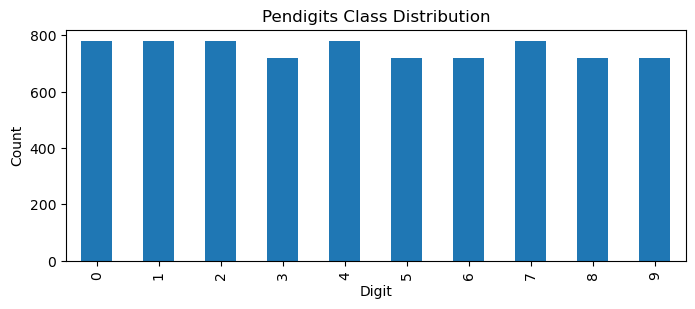

,count,mean,std,min,25%,50%,75%,max
feat0,7494.0,37.384307,33.322024,0.0,5.0,31.0,61.0,100.0
feat1,7494.0,84.679343,16.848420,0.0,76.0,89.0,100.0,100.0
feat2,7494.0,40.005604,26.256025,0.0,20.0,39.0,58.0,100.0
feat3,7494.0,82.889512,19.638582,0.0,70.0,89.0,100.0,100.0
feat4,7494.0,50.878303,34.927201,0.0,17.0,56.0,81.0,100.0
feat5,7494.0,65.044436,27.377341,0.0,48.0,71.0,86.0,100.0
feat6,7494.0,51.471844,30.680075,0.0,28.0,54.0,75.0,100.0
feat7,7494.0,44.599680,30.659478,0.0,22.0,42.0,65.0,100.0
feat8,7494.0,57.129971,33.680340,0.0,30.0,60.0,88.0,100.0
feat9,7494.0,34.069122,27.459989,0.0,7.0,33.0,55.0,100.0


In [3]:
# 2. Basic EDA 
# 2.1 Class distribution
dist = df["digit"].value_counts().sort_index()
plt.figure(figsize=(8,3))
dist.plot.bar(title="Pendigits Class Distribution")
plt.xlabel("Digit"); plt.ylabel("Count")
plt.show()

# 2.2 Feature summary
display(df.drop("digit", axis=1).describe().T)


In [4]:
# 3. Random‐search SVM optimizer 
def random_loguniform(a, b):
    return math.exp(random.uniform(math.log(a), math.log(b)))

def optimize_svm(X_tr, y_tr, X_val, y_val, n_iter=100):
    best_acc, best_params = 0.0, None
    history = []
    for i in range(1, n_iter+1):
        params = {
            "kernel": random.choice(["linear","rbf","poly"]),
            "C": random_loguniform(1e-3, 1e3),
            "gamma": random_loguniform(1e-4, 1e1)
        }
        clf = SVC(**params)
        clf.fit(X_tr, y_tr)
        acc = accuracy_score(y_val, clf.predict(X_val)) * 100
        if acc > best_acc:
            best_acc, best_params = acc, params.copy()
        history.append(best_acc)
    return best_acc, best_params, history


In [ ]:
# 4. Run 10 random 70/30 splits & collect Table 1 
results = []
all_histories = []

for sid in range(1, 11):
    X_tr, X_val, y_tr, y_val = train_test_split(
        X, y, train_size=0.7, shuffle=True, random_state=sid*123
    )
    acc, params, hist = optimize_svm(X_tr, y_tr, X_val, y_val, n_iter=100)
    results.append({
        "Sample": f"S{sid}",
        "Best Accuracy (%)": acc,
        "Kernel": params["kernel"],
        "C": params["C"],
        "Gamma": params["gamma"]
    })
    all_histories.append(hist)

table1 = pd.DataFrame(results)
display(table1)


In [ ]:
# 5. Convergence plot for the best‐accuracy run -------------------------------
best_idx = table1["Best Accuracy (%)"].idxmax()
best_sample = table1.loc[best_idx, "Sample"]
best_history = all_histories[best_idx]

plt.figure(figsize=(8,4))
plt.plot(range(1,101), best_history, linewidth=2)
plt.title(f"Convergence of Best SVM ({best_sample}) on Pendigits")
plt.xlabel("Iteration")
plt.ylabel("Best Accuracy so far (%)")
plt.grid(True)
plt.show()
